In [1]:
import os
import cv2
import pickle
import imutils
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support as prfs

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Dense, Flatten

%matplotlib inline

In [2]:
def load_data(data_path):
    X = []
    y = []
    labels = os.listdir(data_path)
    img_path_per_label = {labels[i]: [os.path.join(data_path, labels[i], img_path) for img_path in os.listdir(data_path + '/' + labels[i])] for i in range(len(labels))}
    for key in list(img_path_per_label.keys()):
        for img_path in img_path_per_label[key]:
            X.append(cv2.resize(cv2.imread(img_path), (30, 30), interpolation=cv2.INTER_BITS2))
            y.append(key)

    return np.array(X), np.array(y)

In [3]:
def increase_brightness(img, value=20):
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv_img)

    limit = 255 - value
    v[v <= limit] += value
    v[v > limit] = 255

    final_hsv = cv2.merge((h, s, v))
    return cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

In [4]:
def display_random_set(data, labels):
    for i in range(10):
        random_val = np.random.randint(low=0, high=len(data))
        plt.subplot(2, 5, (i + 1))
        plt.imshow(imutils.opencv2matplotlib(data[random_val]))
        plt.title(labels[random_val])
        plt.axis(False)
    plt.show()

In [5]:
def build_model(num_classes, img_dim):
    model = Sequential()

    model.add(Conv2D(filters=64, kernel_size=(2, 2), padding='same', activation='relu', input_shape=img_dim))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=64, kernel_size=(2, 2), padding='same', activation='relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=128, kernel_size=(2, 2), padding='same', activation='relu'))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=128, kernel_size=(2, 2), padding='same', activation='relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    sgd = SGD(learning_rate=0.001, nesterov=True, name='SGD_Optimizer')
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy', 'mse'])

    print(model.summary())

    return model

In [6]:
def train_model(x, y, x_val, y_val, model, train=False):
    batch_size = 64
    num_epochs = 25
    if train:
        checkpoint = ModelCheckpoint(filepath='traffic_sign_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
        history = model.fit(x=x, y=y, validation_data=(x_val, y_val), shuffle=True, batch_size=batch_size, epochs=num_epochs, callbacks=[checkpoint], verbose=1)
        save_history_file(file_name='traffic_sign.pickle', history=history)

In [7]:
def save_history_file(file_name, history):
    pickle_out = open(file_name, 'wb')
    pickle.dump(history.history, pickle_out)
    pickle_out.close()


def load_history(file_name):
    pickle_in = open(file_name, 'rb')
    saved_hist = pickle.load(pickle_in)
    return saved_hist


In [8]:
def plot_curves(history):

    plt.figure(figsize=(10, 5))
    sns.set_style(style='dark')
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.xlabel('Iterations')
    plt.ylabel('Error')
    plt.title('Training & Validation Loss')
    plt.legend(['Train loss', 'Validation loss'])

    plt.subplot(1, 2, 2)
    plt.plot(history['mse'])
    plt.plot(history['val_mse'])
    plt.xlabel('Iterations')
    plt.ylabel('Error')
    plt.title('Training & Validation MSE')
    plt.legend(['Train mse', 'Validation mse'])

    plt.show()


def accuracy_per_class(labels, precision, recall, f1):
    # plt.subplots(figsize=(18, 30))

    x = range(len(labels))
    plt.subplot(3, 1, 1)
    plt.title("Precision per class")
    plt.ylim(0, 1.00)
    plt.bar(x, precision, color='Red')
    plt.xticks(x, rotation=90)

    plt.subplot(312)
    plt.title('Recall per class')
    plt.ylim(0, 1.00)
    plt.bar(x, recall, color='Green')
    plt.xticks(x, rotation=90)

    plt.subplot(313)
    plt.title('F1 score per class')
    plt.ylim(0, 1.00)
    plt.bar(x, f1, color='Blue')
    plt.xticks(x, rotation=90)
    plt.show()

In [9]:
def load_test_data(test_data_dir, test_data_labels_dir):
    # reading csv file
    data = np.loadtxt(test_data_labels_dir, delimiter=',', skiprows=1, dtype=str)
    x_test = np.array([os.path.join(test_data_dir, img_name) for img_name in data[:, 0]])
    x_test = np.array([cv2.resize(cv2.imread(img_path), (30, 30), interpolation=cv2.INTER_BITS2) for img_path in x_test])
    y_test = np.array(data[:, 1]).astype(np.int)

    return x_test, y_test

In [10]:
def main():
    # Reading Data from folders
    X, y = load_data(data_path='./crop_dataset/crop_dataset/')
    print(f"Data shape: {X.shape},   Labels: {y.shape}\n")

    # Displaying random set of images from data
    display_random_set(data=X, labels=y)

    # Splitting data into training and testing data, training will consist of 70% of the data and 30% of the remaining
    # will be testing data.
    x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
    print(f"Training Data: {x_train.shape},   Training labels: {y_train.shape}\nValidation Data: {x_val.shape},   "
          f"Validation labels: {y_val.shape}\n")

    # Adjusting labels to be represented as categorical data.
    y_train = to_categorical(y=y_train, num_classes=len(np.unique(y)))
    y_val = to_categorical(y=y_val, num_classes=len(np.unique(y)))

    # Creating Neural network model.
    model = build_model(num_classes=len(np.unique(y)), img_dim=x_train[0].shape)

    # To train the model again change train value to True, change to False to not train.
    train_model(x=x_train, y=y_train, x_val=x_val, y_val=y_val, model=model, train=True)

    print("[In progress] Loading H5 model and history file...")
    classifier = load_model(filepath='traffic_sign_model.h5')
    hist_loaded = load_history(file_name='traffic_sign.pickle')
    print("[Done] Loading H5 model and history file...")

    # Loading data for testing model.
    x_test, y_test = load_test_data(test_data_dir='./test_data/test_data', test_data_labels_dir='./test_labels.csv')
    predictions = classifier.predict_classes(x_test)
    accuracy = np.array([1 if predictions[i] == int(y_test[i]) else 0 for i in range(len(predictions))])
    print(f"Accuracy on test data: {np.mean(accuracy) * 100} %.")

    # plotting loss and mse curves for training and validation steps
    plot_curves(hist_loaded)

    # plotting accuracy bar graph per class
    labels = np.unique(y)
    precision, recall, f1, support = prfs(y_true=y_test, y_pred=predictions, average=None)
    accuracy_per_class(labels, precision, recall, f1)


Data shape: (26640, 30, 30, 3),   Labels: (26640,)



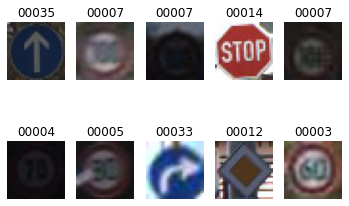

Training Data: (18648, 30, 30, 3),   Training labels: (18648,)
Validation Data: (7992, 30, 30, 3),   Validation labels: (7992,)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 64)        832       
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 64)        16448     
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 128)       3289

18624/18648 [============================>.] - ETA: 0s - loss: 0.1765 - categorical_accuracy: 0.9627 - mse: 0.0016 ETA: 0s - loss: 0.1755 - categorical_accuracy: 0.9631 - m
Epoch 00014: val_loss improved from 0.20700 to 0.18410, saving model to traffic_sign_model.h5
18648/18648 [==============================] - 10s 553us/sample - loss: 0.1764 - categorical_accuracy: 0.9627 - mse: 0.0016 - val_loss: 0.1841 - val_categorical_accuracy: 0.9586 - val_mse: 0.0017
Epoch 15/25
18624/18648 [============================>.] - ETA: 0s - loss: 0.1569 - categorical_accuracy: 0.9689 - mse: 0.0014
Epoch 00015: val_loss improved from 0.18410 to 0.17436, saving model to traffic_sign_model.h5
18648/18648 [==============================] - 10s 551us/sample - loss: 0.1568 - categorical_accuracy: 0.9689 - mse: 0.0014 - val_loss: 0.1744 - val_categorical_accuracy: 0.9621 - val_mse: 0.0016
Epoch 16/25
18624/18648 [============================>.] - ETA: 0s - loss: 0.1420 - categorical_accuracy: 0.9708 - mse: 

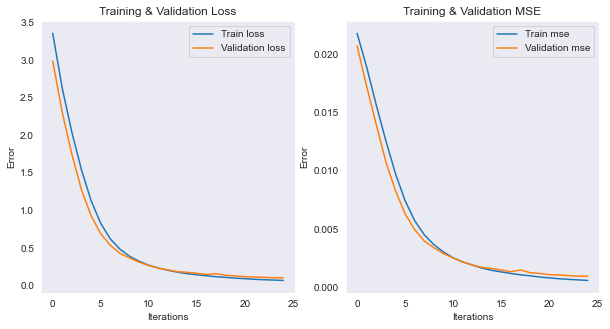

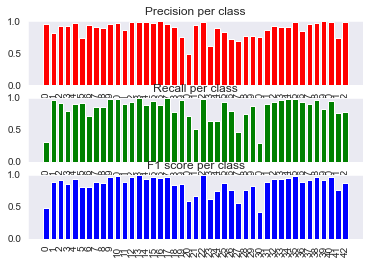

In [11]:
if __name__ == '__main__':
    main()